# <center> **-- Deep Convolutional Generative Adversarial Network --** </center>

<br/>

## <font size="20"> &#10148; </font> Introduction

- In this work, a deep convolutional generative adversarial network is trained. The model architecture is an expansion on the original DCGAN architecture in [<em>`Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks`</em>](https://arxiv.org/abs/1511.06434). With the enhancement in model architecture, the model is capable of generating images of 128 * 128 resolution (originally 64 * 64). We train the DCGAN on a fraction of the [<em> `Large-scale CelebFaces Attributes (CelebA) Dataset` </em>](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), a image dataset contains 202,599 number of face images, with binary attributes (labels are **NOT** used in this work).
- Images from the dataset are 178 * 218 , and is adjusted to 128 * 128 (via CenterCrop() function from cv2). 
- The model is trained on a single A100 GPU for 120 epoches. It takes around <span style="color:red"> **15 hours**</span> to finish the training. 
- Reducing the size of the latent space will largely save the computation time. 
- Due to very limited time we have to finish this project, we didn't perform much hyperparameter tuning. We use the learning rate from reproduced original DCGAN found online.
- Images generated showed good performance of the model.


<br/>

## <font size="20"> &#8681; </font> Import

In [1]:
# import
#--------------------------------------------------#
import os 
import sys
import os.path
from sys import platform
from pathlib import Path
#--------------------------------------------------#
import re
import sys
import time
import copy
import math
import html
import scipy
import pickle
import random
import argparse
import subprocess
import numpy as np
import pandas as pd

#--------------------------------------------------#
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

#--------------------------------------------------#
import cv2

#--------------------------------------------------#
from tqdm.notebook import tqdm

#--------------------------------------------------#
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

#--------------------------------------------------#
%matplotlib inline


#--------------------------------------------------#
# Ensure reproducibility.
seed = 42 # 42, 0, 1, 2, 3, 4
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


<br/>

## <font size="20"> &#8681; </font> Load Dataset

In [2]:
# Load dataset from the root dir.
data_folder = "./input/celeba"
print("Some image names: ", os.listdir(data_folder)[:5])


# Basic Settings for Training/Model.
batch_size      = 256       # Batch size for training the model. 
image_size      = 128       # Image size to be transformed into. 
stats           = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)


# These detailed settings of the model are specified in later block.
# num_channel     = 3         # Number of channels (for color images num_channel = 3)
# size_latent     = 128       # Size of z latent vector.
# size_feat_map_g = 64        # Size of feature maps in generator.
# size_feat_map_d = 64        # Size of feature maps in discriminator.
# num_epochs      = 60        # Number of training epochs.
# lr              = 0.0002    # Learning rate. 
# beta1           = 0.5       # Beta1 hyperparam for Adam optimizers.


# Load Image dataset. 
train_ds = ImageFolder(data_folder, transform = tt.Compose([ tt.Resize    (image_size) ,
                                                             tt.CenterCrop(image_size) ,
                                                             tt.ToTensor  ()           ,
                                                             tt.Normalize (*stats)     , ])
                       )  


# Load into DataLoader.
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

Some image names:  ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg']


## <font size="20"> &#8681; </font> Define functions for showing the images

In [3]:

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax = 64):
    fig, ax = plt.subplots(figsize = (6, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[ : nmax ]), nrow = 6).permute(1, 2, 0))
    return 




## <font size="20"> &#8681; </font> Load data into device with CPU/GPU compatibility

In [4]:
def is_cuda_available():
    if torch.cuda.is_available():
        print("CUDA available. Training on GPU!")
        return torch.device('cuda')
    else:
        print("CUDA not available. Training on CPU!")
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)


device = is_cuda_available()

train_dl = DeviceDataLoader(train_dl, device)

CUDA available. Training on GPU!


## <font size="20"> &#8681; </font> Model Settings

In [5]:
num_channel     = 3         # Number of channels (for color images num_channel = 3)
size_latent     = 128       # Size of z latent vector.
size_feat_map_g = 64        # Size of feature maps in generator.
size_feat_map_d = 64        # Size of feature maps in discriminator.
num_epochs      = 60        # Number of training epochs.
lr              = 0.0002    # Learning rate. 
beta1           = 0.5       # Beta1 hyperparam for Adam optimizers.

## <font size="20"> &#8681; </font> Define Discriminator

In [6]:
# CNN with Convolutional layers.
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(num_channel         , 
              size_feat_map_d     , 
              kernel_size = 4     , 
              stride      = 2     , 
              padding     = 1     , 
              bias        = False ),
    nn.BatchNorm2d(size_feat_map_d),
    nn.LeakyReLU(0.2, inplace=True),
    # out: ... x 64 x 64

    nn.Conv2d(size_feat_map_d * 1 , 
              size_feat_map_d * 2 , 
              kernel_size = 4     , 
              stride      = 2     , 
              padding     = 1     , 
              bias        = False ),
    nn.BatchNorm2d(size_feat_map_d * 2),
    nn.LeakyReLU(0.2, inplace=True),
    # out: ... x 32 x 32

    nn.Conv2d(size_feat_map_d * 2 , 
              size_feat_map_d * 4 , 
              kernel_size = 4     , 
              stride      = 2     , 
              padding     = 1     , 
              bias        = False ),
    nn.BatchNorm2d(size_feat_map_d * 4),
    nn.LeakyReLU(0.2, inplace=True),
    # out: ... x 16 x 16

    nn.Conv2d(size_feat_map_d * 4 , 
              size_feat_map_d * 8 , 
              kernel_size = 4     , 
              stride      = 2     , 
              padding     = 1     , 
              bias        = False ),
    nn.BatchNorm2d(size_feat_map_d * 8),
    nn.LeakyReLU(0.2, inplace=True),
    # out: ... x 8 x 8

    nn.Conv2d(size_feat_map_d * 8  , 
              size_feat_map_d * 16 , 
              kernel_size = 4      , 
              stride      = 2      , 
              padding     = 1      , 
              bias        = False ),
    nn.BatchNorm2d(size_feat_map_d * 16),
    nn.LeakyReLU(0.2, inplace=True),
    # out: ... x 4 x 4


    nn.Conv2d(size_feat_map_d * 16, 
              1                   , 
              kernel_size = 4     , 
              stride      = 2     ,
              padding     = 0     , 
              bias        = False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

discriminator = to_device(discriminator, device)

## <font size="20"> &#8681; </font> Define Generator

In [7]:
# CNN with Convolutional layers.
generator = nn.Sequential(

    # Input: N x size_latent_z x 1 x 1
    nn.ConvTranspose2d(size_latent         , 
                       size_feat_map_g * 32, 
                       kernel_size = 4     , 
                       stride      = 2     , 
                       padding     = 0     , 
                       bias        = False),
    nn.BatchNorm2d(size_feat_map_g * 32),
    nn.ReLU(True),
    # out: ... x 4 x 4 


    nn.ConvTranspose2d(size_feat_map_g * 32, 
                       size_feat_map_g * 16, 
                       kernel_size = 4     , 
                       stride      = 2     , 
                       padding     = 1     , 
                       bias        = False),
    nn.BatchNorm2d(size_feat_map_g * 16),
    nn.ReLU(True),
    # out: ... x 8 x 8 

    nn.ConvTranspose2d(size_feat_map_g * 16, 
                       size_feat_map_g * 8 , 
                       kernel_size = 4     , 
                       stride      = 2     , 
                       padding     = 1     , 
                       bias        = False),
    nn.BatchNorm2d(size_feat_map_g * 8),
    nn.ReLU(True),
    # out: ... x 16 x 16 

    nn.ConvTranspose2d(size_feat_map_g * 8 , 
                       size_feat_map_g * 4 , 
                       kernel_size = 4     , 
                       stride      = 2     , 
                       padding     = 1     , 
                       bias        = False),
    nn.BatchNorm2d(size_feat_map_g * 4),
    nn.ReLU(True),
    # out: ... x 32 x 32 

    nn.ConvTranspose2d(size_feat_map_g * 4 , 
                       size_feat_map_g * 2 , 
                       kernel_size = 4     , 
                       stride      = 2     , 
                       padding     = 1     , 
                       bias        = False),
    nn.BatchNorm2d(size_feat_map_g * 2),
    nn.ReLU(True),
    # out: ... x 64 x 64 


    nn.ConvTranspose2d(size_feat_map_g * 2 , 
                       num_channel         , 
                       kernel_size = 4     , 
                       stride      = 2     , 
                       padding     = 1     , 
                       bias        = False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

random_latent_vector = torch.randn(batch_size, size_latent, 1, 1) 
fake_images = generator(random_latent_vector)
print("Shape of fake image: ", fake_images.shape)

generator = to_device(generator, device)

Shape of fake image:  torch.Size([256, 3, 128, 128])


## <font size="20"> &#8681; </font> Function To Train Discriminator

- Initialize gradients.
- Pass real images through discriminator.
- Generate fake images.
- Pass fake images through discriminator.
- Update discriminator weights.
- Save the model parameters for future use.

In [8]:

def train_discriminator(real_img, optimizer_discriminator, epoch_num = 0, if_save = False ):

    # Initialize gradients
    optimizer_discriminator.zero_grad()

    # Pass real images through discriminator
    real_preds   = discriminator(real_img)
    real_targets = torch.ones(real_img.size(0), 1, device = device)
    real_loss    = F.binary_cross_entropy(real_preds, real_targets)
    real_score   = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, size_latent, 1, 1, device=device)
    fake_images = generator(latent)


    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds   = discriminator(fake_images)
    fake_loss    = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score   = torch.mean(fake_preds).item()


    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    optimizer_discriminator.step()
    
    # Save the model for later image generation.
    # if if_save:
    #     torch.save(generator.state_dict(), 'Saving_folder/generator_celeba_' + str(epoch_num) + '.pt')

    return loss.item(), real_score, fake_score

## <font size="20"> &#8681; </font> Function To Train Generator

- Initiate generator gradients
- Generate fake images
- Try to fool the discriminator
- Update generator weights

In [9]:

def train_generator(optimizer_generator):
    # Initiate generator gradients
    optimizer_generator.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, size_latent, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    optimizer_generator.step()
    
    return loss.item()


## <font size="20"> &#8681; </font> Function To Save the Sample Output.

In [10]:

def save_samples(index, latent_tensors, show = True):
    fake_images = generator(latent_tensors)
    fake_img_nme = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(image_folder, fake_img_nme), nrow = 6)
    print('Saving', fake_img_nme)
    if show:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow = 6).permute(1, 2, 0))


image_folder = 'generated'

os.makedirs(image_folder, exist_ok = True)

fixed_latent = torch.randn(36, size_latent, 1, 1, device = device)

save_samples(0, fixed_latent, show = False)

print()

Saving generated-images-0000.png



## <font size="20"> &#8681; </font> Function to Run Training.

In [11]:

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))
    optimizer_generator = torch.optim.Adam(generator    .parameters(), lr = lr, betas = (0.5, 0.999))
    
    for epoch in range(epochs):
        for idx, (real_img, _) in enumerate(tqdm(train_dl)):
            if idx == 0:
                print("First Image of this Epoch, Save a temp Model.")
                if_save = True
            else:
                if_save = False
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_img, optimizer_discriminator, epoch_num = epoch, if_save = if_save)
            # Train generator
            loss_g = train_generator(optimizer_generator)
            
        # Save to list. 
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch + 1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch + start_idx, fixed_latent, show = False)
    
        torch.save(generator.state_dict(), 'Saving_folder/generator_celeba_' + str(epoch) + '.pt')

    return losses_g, losses_d, real_scores, fake_scores

## <font size="20"> &#8681; </font> Run Train.

- Training the model requires some good computation resources.
- We have used a A100 GPU (w/ 40GB VRAM) and a system that guarantees 186GB RAM.
- Training 120 Epoch takes around 15 hours.
- Training a orginal DCGAN (64 x 64) takes less than 1 hour on A100. 
- GAN can be SUPERRR HARD to tune as it is very sensitive to hyperparameter. 
    - With relatively smaller sizes of feature maps used, the GAN would suddenly start to generate very poor images. 
    - We have used relatively larger sizes of feature maps as well as an increased value for size of latent space. 
    - Increasing these hyperparameters make the runtime even longer.


In [33]:
# Set the epoch number and train.

epochs = 60

losses_g, losses_d, real_scores, fake_scores = fit(epochs, lr)


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [1/60], loss_g: 7.2076, loss_d: 0.0033, real_score: 0.9975, fake_score: 0.0008
Saving generated-images-0001.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [2/60], loss_g: 6.7714, loss_d: 0.2975, real_score: 0.9343, fake_score: 0.1873
Saving generated-images-0002.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [3/60], loss_g: 5.0229, loss_d: 0.5283, real_score: 0.9414, fake_score: 0.3497
Saving generated-images-0003.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [4/60], loss_g: 4.7352, loss_d: 0.3894, real_score: 0.9864, fake_score: 0.2964
Saving generated-images-0004.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [5/60], loss_g: 1.8691, loss_d: 0.7678, real_score: 0.5590, fake_score: 0.0983
Saving generated-images-0005.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [6/60], loss_g: 4.0537, loss_d: 0.1260, real_score: 0.9954, fake_score: 0.1090
Saving generated-images-0006.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [7/60], loss_g: 4.3578, loss_d: 0.6302, real_score: 0.9703, fake_score: 0.3923
Saving generated-images-0007.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [8/60], loss_g: 5.4764, loss_d: 0.0232, real_score: 0.9867, fake_score: 0.0095
Saving generated-images-0008.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [9/60], loss_g: 3.5792, loss_d: 0.1053, real_score: 0.9408, fake_score: 0.0398
Saving generated-images-0009.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [10/60], loss_g: 8.6806, loss_d: 0.2863, real_score: 0.9975, fake_score: 0.2261
Saving generated-images-0010.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [11/60], loss_g: 9.9050, loss_d: 0.2627, real_score: 0.9969, fake_score: 0.1970
Saving generated-images-0011.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [12/60], loss_g: 6.1633, loss_d: 2.5519, real_score: 0.1760, fake_score: 0.0000
Saving generated-images-0012.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [13/60], loss_g: 4.0173, loss_d: 0.1669, real_score: 0.8858, fake_score: 0.0161
Saving generated-images-0013.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [14/60], loss_g: 5.6818, loss_d: 0.1494, real_score: 0.9730, fake_score: 0.1096
Saving generated-images-0014.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [15/60], loss_g: 6.1198, loss_d: 0.0754, real_score: 0.9786, fake_score: 0.0492
Saving generated-images-0015.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [16/60], loss_g: 6.2382, loss_d: 0.0597, real_score: 0.9577, fake_score: 0.0123
Saving generated-images-0016.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [17/60], loss_g: 5.3178, loss_d: 0.0860, real_score: 0.9588, fake_score: 0.0369
Saving generated-images-0017.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [18/60], loss_g: 5.9916, loss_d: 0.1031, real_score: 0.9714, fake_score: 0.0664
Saving generated-images-0018.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [19/60], loss_g: 1.8603, loss_d: 1.7339, real_score: 0.3261, fake_score: 0.0000
Saving generated-images-0019.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [20/60], loss_g: 4.6103, loss_d: 0.2133, real_score: 0.8978, fake_score: 0.0520
Saving generated-images-0020.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [21/60], loss_g: 6.6681, loss_d: 0.0885, real_score: 0.9804, fake_score: 0.0626
Saving generated-images-0021.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [22/60], loss_g: 5.4861, loss_d: 0.1103, real_score: 0.9189, fake_score: 0.0050
Saving generated-images-0022.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [23/60], loss_g: 7.3084, loss_d: 0.0813, real_score: 0.9981, fake_score: 0.0648
Saving generated-images-0023.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [24/60], loss_g: 12.0619, loss_d: 0.3108, real_score: 0.9919, fake_score: 0.2235
Saving generated-images-0024.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [25/60], loss_g: 6.2034, loss_d: 0.0772, real_score: 0.9857, fake_score: 0.0494
Saving generated-images-0025.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [26/60], loss_g: 5.8027, loss_d: 0.1937, real_score: 0.9126, fake_score: 0.0473
Saving generated-images-0026.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [27/60], loss_g: 4.8786, loss_d: 0.0483, real_score: 0.9659, fake_score: 0.0095
Saving generated-images-0027.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [28/60], loss_g: 7.5824, loss_d: 0.0165, real_score: 0.9921, fake_score: 0.0083
Saving generated-images-0028.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [29/60], loss_g: 7.5622, loss_d: 0.0816, real_score: 0.9578, fake_score: 0.0262
Saving generated-images-0029.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [30/60], loss_g: 6.2255, loss_d: 0.0809, real_score: 0.9861, fake_score: 0.0592
Saving generated-images-0030.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [31/60], loss_g: 6.1594, loss_d: 0.1181, real_score: 0.9935, fake_score: 0.0780
Saving generated-images-0031.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [32/60], loss_g: 5.7703, loss_d: 0.1037, real_score: 0.9558, fake_score: 0.0459
Saving generated-images-0032.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [33/60], loss_g: 5.2575, loss_d: 0.0317, real_score: 0.9786, fake_score: 0.0087
Saving generated-images-0033.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [34/60], loss_g: 5.0936, loss_d: 0.0327, real_score: 0.9803, fake_score: 0.0109
Saving generated-images-0034.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [35/60], loss_g: 6.2342, loss_d: 0.0562, real_score: 0.9815, fake_score: 0.0323
Saving generated-images-0035.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [36/60], loss_g: 4.0774, loss_d: 0.0847, real_score: 0.9844, fake_score: 0.0585
Saving generated-images-0036.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [37/60], loss_g: 2.1405, loss_d: 0.2727, real_score: 0.8297, fake_score: 0.0086
Saving generated-images-0037.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [38/60], loss_g: 6.6532, loss_d: 0.0757, real_score: 0.9568, fake_score: 0.0059
Saving generated-images-0038.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [39/60], loss_g: 4.0091, loss_d: 0.0482, real_score: 0.9696, fake_score: 0.0137
Saving generated-images-0039.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [40/60], loss_g: 4.1913, loss_d: 0.1170, real_score: 0.9250, fake_score: 0.0203
Saving generated-images-0040.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [41/60], loss_g: 2.2720, loss_d: 1.1952, real_score: 0.5107, fake_score: 0.0003
Saving generated-images-0041.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [42/60], loss_g: 7.0827, loss_d: 0.1378, real_score: 0.9087, fake_score: 0.0002
Saving generated-images-0042.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [43/60], loss_g: 5.5431, loss_d: 0.2029, real_score: 0.8717, fake_score: 0.0068
Saving generated-images-0043.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [44/60], loss_g: 4.4330, loss_d: 0.0804, real_score: 0.9427, fake_score: 0.0146
Saving generated-images-0044.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [45/60], loss_g: 6.0827, loss_d: 0.0238, real_score: 0.9893, fake_score: 0.0125
Saving generated-images-0045.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [46/60], loss_g: 5.1263, loss_d: 0.0162, real_score: 0.9846, fake_score: 0.0000
Saving generated-images-0046.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [47/60], loss_g: 6.4786, loss_d: 0.0112, real_score: 0.9925, fake_score: 0.0031
Saving generated-images-0047.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [48/60], loss_g: 6.0804, loss_d: 0.0963, real_score: 0.9656, fake_score: 0.0511
Saving generated-images-0048.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [49/60], loss_g: 5.1569, loss_d: 0.0068, real_score: 0.9992, fake_score: 0.0059
Saving generated-images-0049.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [50/60], loss_g: 5.8309, loss_d: 0.0685, real_score: 0.9479, fake_score: 0.0079
Saving generated-images-0050.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [51/60], loss_g: 6.8653, loss_d: 0.0298, real_score: 0.9931, fake_score: 0.0215
Saving generated-images-0051.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [52/60], loss_g: 6.6835, loss_d: 0.1252, real_score: 0.9895, fake_score: 0.0944
Saving generated-images-0052.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [53/60], loss_g: 12.5768, loss_d: 0.0540, real_score: 0.9606, fake_score: 0.0067
Saving generated-images-0053.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [54/60], loss_g: 6.1646, loss_d: 0.0258, real_score: 0.9882, fake_score: 0.0130
Saving generated-images-0054.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [55/60], loss_g: 6.6456, loss_d: 0.0729, real_score: 0.9797, fake_score: 0.0446
Saving generated-images-0055.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [56/60], loss_g: 19.8233, loss_d: 4.2771, real_score: 1.0000, fake_score: 0.8486
Saving generated-images-0056.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [57/60], loss_g: 8.1949, loss_d: 0.0086, real_score: 0.9955, fake_score: 0.0039
Saving generated-images-0057.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [58/60], loss_g: 6.9804, loss_d: 0.1620, real_score: 0.9908, fake_score: 0.1207
Saving generated-images-0058.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [59/60], loss_g: 8.6031, loss_d: 0.1127, real_score: 0.9982, fake_score: 0.0864
Saving generated-images-0059.png


  0%|          | 0/792 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [60/60], loss_g: 5.1035, loss_d: 0.0395, real_score: 0.9812, fake_score: 0.0190
Saving generated-images-0060.png


## <font size="20"> &#8681; </font> Print out the Losses and Scores and Save. 

In [12]:


# print(losses_d   )
# print(losses_g   )
# print(fake_scores)
# print(real_scores)

losses_d     = [0.003302590921521187, 0.29748988151550293, 0.5282654166221619, 0.3894405663013458, 0.7678394913673401, 0.12602823972702026, 0.6301745176315308, 0.023221919313073158, 0.10533767193555832, 0.28627413511276245, 0.26268258690834045, 2.5519001483917236, 0.16691213846206665, 0.14942458271980286, 0.07537579536437988, 0.059658534824848175, 0.085956871509552, 0.10310538113117218, 1.7338831424713135, 0.21331575512886047, 0.08848164230585098, 0.11034898459911346, 0.08126925677061081, 0.310846745967865, 0.077169269323349, 0.19369086623191833, 0.0482863113284111, 0.01652393862605095, 0.0815950334072113, 0.08088410645723343, 0.11811273545026779, 0.10365812480449677, 0.03171626105904579, 0.032671451568603516, 0.05621476471424103, 0.08474268019199371, 0.27272161841392517, 0.07571855932474136, 0.048239607363939285, 0.11695878207683563, 1.1951649188995361, 0.13784119486808777, 0.20290343463420868, 0.08044786006212234, 0.023829948157072067, 0.01617218367755413, 0.01116202212870121, 0.09629213809967041, 0.006802644580602646, 0.06846833974123001, 0.029787642881274223, 0.12524054944515228, 0.05404334515333176, 0.025834795087575912, 0.0728621780872345, 4.277144432067871, 0.008615627884864807, 0.1619904488325119, 0.11267814040184021, 0.03951100632548332]
losses_g     = [7.207609176635742, 6.7714385986328125, 5.0229268074035645, 4.735162734985352, 1.8691046237945557, 4.053672790527344, 4.357817649841309, 5.476443290710449, 3.579174041748047, 8.680585861206055, 9.904966354370117, 6.1632513999938965, 4.0172576904296875, 5.68178653717041, 6.119837284088135, 6.238181114196777, 5.317849159240723, 5.9915995597839355, 1.860335111618042, 4.61030387878418, 6.668132781982422, 5.486145973205566, 7.308364391326904, 12.061908721923828, 6.203441619873047, 5.802748203277588, 4.878605842590332, 7.582378387451172, 7.562232971191406, 6.225526809692383, 6.1594390869140625, 5.770308017730713, 5.257513999938965, 5.09361457824707, 6.2342305183410645, 4.07735538482666, 2.1405491828918457, 6.653242111206055, 4.00908088684082, 4.191252708435059, 2.2719500064849854, 7.082746505737305, 5.543099403381348, 4.4329681396484375, 6.082673072814941, 5.126276969909668, 6.478618621826172, 6.08035945892334, 5.156939506530762, 5.830863952636719, 6.865322113037109, 6.683498382568359, 12.576804161071777, 6.164568901062012, 6.64557409286499, 19.82330322265625, 8.19489860534668, 6.980443000793457, 8.603135108947754, 5.10346794128418]
fake_scores  = [0.0007722775917500257, 0.18730920553207397, 0.34968847036361694, 0.29636621475219727, 0.09827503561973572, 0.10897316783666611, 0.39230963587760925, 0.00953766331076622, 0.03978560492396355, 0.22605961561203003, 0.1969526708126068, 6.011381628923118e-06, 0.016131091862916946, 0.10961271822452545, 0.04920565336942673, 0.012267637066543102, 0.0369342602789402, 0.06636035442352295, 2.7510324798640795e-05, 0.052024949342012405, 0.06257094442844391, 0.0050092898309230804, 0.06478216499090195, 0.22348205745220184, 0.04940575361251831, 0.047275032848119736, 0.009506581351161003, 0.008270028978586197, 0.026181936264038086, 0.05920332670211792, 0.0779651403427124, 0.045896753668785095, 0.008668342605233192, 0.010893002152442932, 0.03234485164284706, 0.05854418873786926, 0.008566748350858688, 0.005904374178498983, 0.013723062351346016, 0.020330511033535004, 0.00032692658714950085, 0.00017037580255419016, 0.006769229657948017, 0.014640973880887032, 0.012542512267827988, 6.786162742855595e-08, 0.003050518687814474, 0.051063090562820435, 0.00589611055329442, 0.007936435751616955, 0.02152351662516594, 0.09441650658845901, 0.006691657938063145, 0.013005479238927364, 0.04456179216504097, 0.8486195802688599, 0.003945870324969292, 0.12072403728961945, 0.08642524480819702, 0.019008344039320946]
real_scores  = [0.9974849224090576, 0.934251606464386, 0.9414419531822205, 0.9864267706871033, 0.5590295791625977, 0.9954347610473633, 0.9702877998352051, 0.9866613149642944, 0.9408411383628845, 0.99751877784729, 0.9969171285629272, 0.17595654726028442, 0.8857900500297546, 0.9730347394943237, 0.9785584211349487, 0.957733154296875, 0.9587804675102234, 0.9714066386222839, 0.32608601450920105, 0.89784175157547, 0.9803568124771118, 0.9189262390136719, 0.9980701208114624, 0.9919447302818298, 0.9856683611869812, 0.9125876426696777, 0.9659126996994019, 0.9921125769615173, 0.9577717781066895, 0.986118733882904, 0.9935044050216675, 0.9558496475219727, 0.9785575866699219, 0.9802877306938171, 0.9815462231636047, 0.9844203591346741, 0.8296765089035034, 0.9568060040473938, 0.9696417450904846, 0.9250329732894897, 0.510735273361206, 0.9086578488349915, 0.8716984987258911, 0.942698061466217, 0.9893240928649902, 0.9845597147941589, 0.9924749135971069, 0.9655551314353943, 0.9991668462753296, 0.9478546380996704, 0.9931101202964783, 0.9894698858261108, 0.9605676531791687, 0.9881930947303772, 0.9796920418739319, 0.9999865293502808, 0.9955241680145264, 0.9907942414283752, 0.9981898665428162, 0.9812131524085999]


## <font size="20"> &#8681; </font> Display image generated in the middle of training.

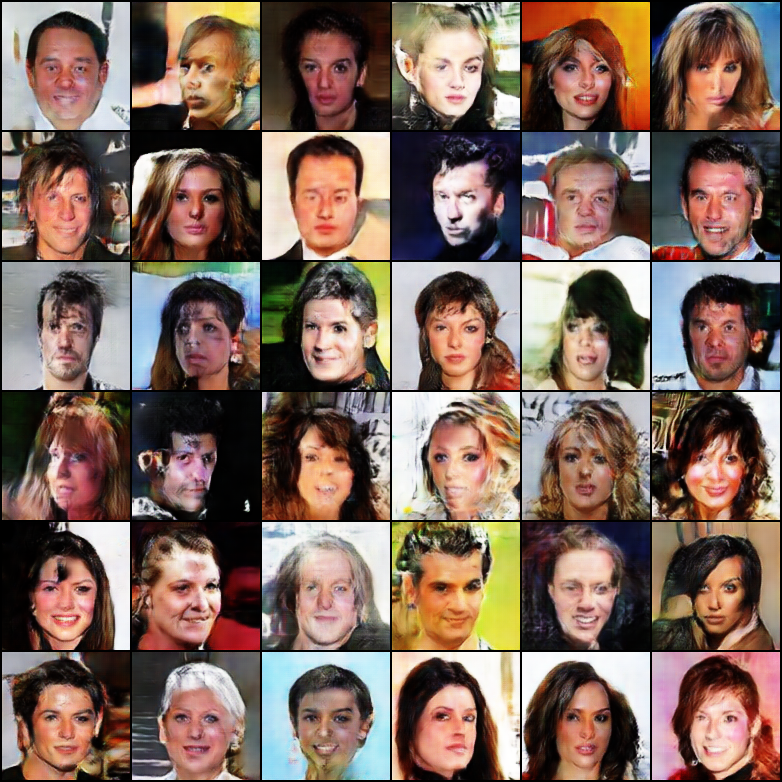

In [13]:
# Display an intermediate image.

from IPython.display import Image
Image('./generated/run_4_E/generated-images-0037.png')

## <font size="20"> &#8681; </font> Make the Images Generated in Each Epoch into a Video.

In [15]:
# Generate a video.

video_files_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if 'generated' in f]
video_files_list.sort()

video_files_list = video_files_list + [video_files_list[-1] for i in range(30)]

video_out = cv2.VideoWriter('DCGAN_Training_EH.avi',                                              # Video Name.
                            cv2.VideoWriter_fourcc(*'MP4V'),                                   # format.
                            5,                                                                 # Number of images per second. 
                            ( (image_size * 6 + 2 * (6+1) ) , (image_size * 6 + 2 * (6+1) ))   # Size of video has to match the image size.
                            )

[video_out.write(cv2.imread(video_file)) for video_file in video_files_list]
video_out.release()



## <font size="20"> &#8681; </font> Make a Plot Based on Saved Losses

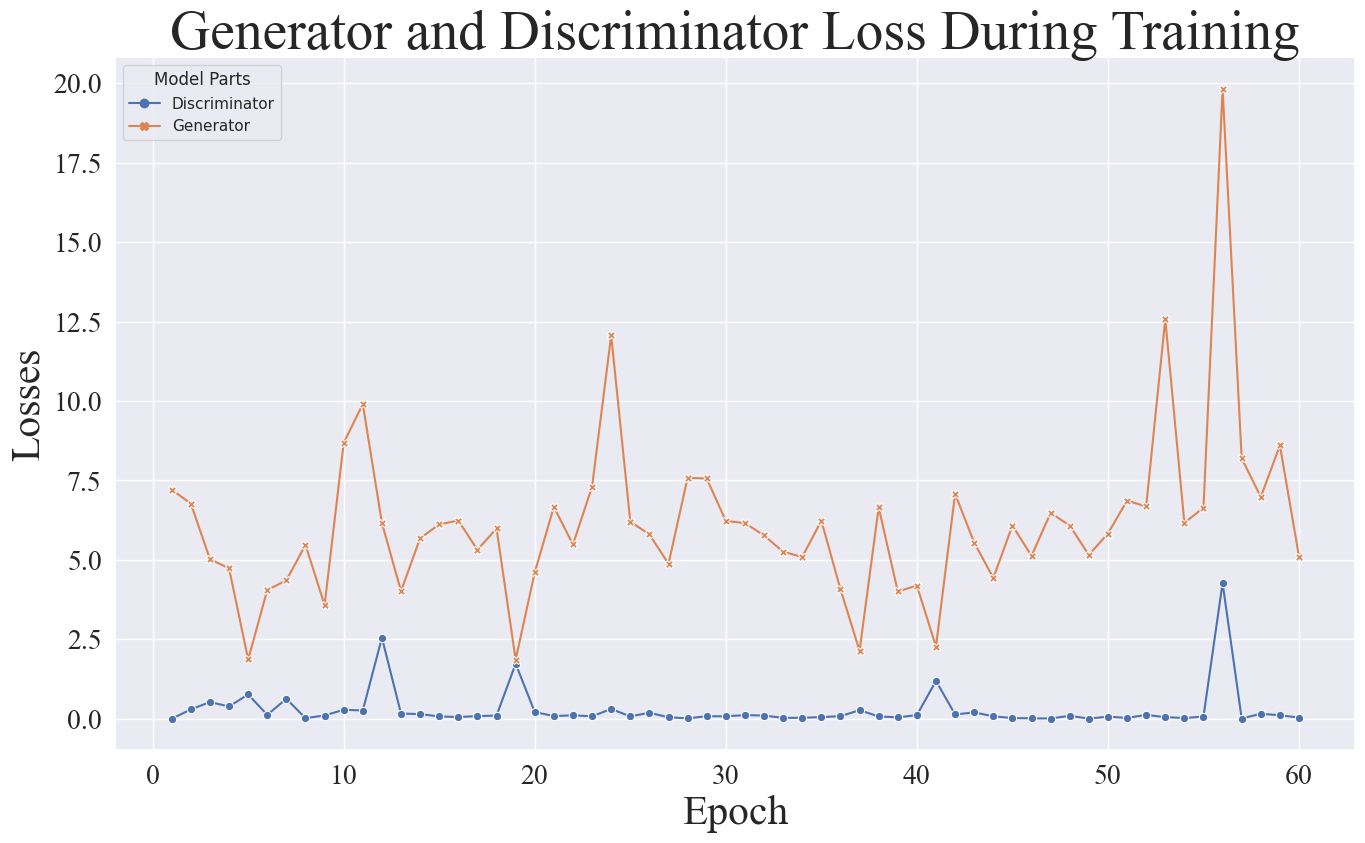

In [16]:
# Load saved training results.
# losses_d    = []
# losses_g    = []
# fake_scores = []
# real_scores = []

# Create a DF for plotting the losses.
losses_list = losses_d + losses_g
hue_list    = ["Discriminator"] * len(losses_d) + ["Generator"] * len(losses_g)
epoch_list  = [i+1 for i in range(len(losses_d))] + [i+1 for i in range(len(losses_d))] 

import pandas as pd
df_losses = pd.DataFrame({'Losses' : losses_list , 'Model Parts' : hue_list, 'Epoch' : epoch_list})

output_file_header = "Saving_Plot_Losses_EnhancedDCGAN_"

fig= plt.figure(figsize=(16, 9))
main_color = sns.color_palette("autumn", 6)

sns.set(style = "darkgrid")

ax = sns.lineplot(data = df_losses,
                  x = "Epoch", y = "Losses", hue = "Model Parts", style = "Model Parts",
                  markers=True, dashes=False
                  )
#--------------------------------------------------#
font = {'family' : "Times New Roman"}
plt.rc('font', **font)
mpl.rc('font', family = 'serif', serif = "Times New Roman")
#--------------------------------------------------#
plt.rc('font', **font)
plt.rc('font', size = 20)             # controls default text sizes
plt.rc('axes', titlesize = 20)        # fontsize of the axes title
plt.rc('axes', labelsize = 20)        # fontsize of the x and y labels
#--------------------------------------------------#
plt.rc('xtick',  labelsize = 20, )    # fontsize of the tick labels
plt.rc('ytick',  labelsize = 20, )    # fontsize of the tick labels
plt.rc('legend', fontsize  = 20, )    # legend fontsize
plt.rc('figure', titlesize = 20, )    # fontsize of the figure title
#--------------------------------------------------#
plt.xticks(fontsize = 20, rotation = 0, **font)
plt.yticks(fontsize = 20, **font)
#--------------------------------------------------#
x_title = "Epoch"
y_title = "Losses"
p_title = 'Generator and Discriminator Loss During Training'
#--------------------------------------------------#
plt.xlabel(x_title, fontsize = 30, **font)
plt.ylabel(y_title, fontsize = 30, **font)
plt.title (p_title, fontsize = 40, **font)
#--------------------------------------------------#
plt.rc('font', **font)
mpl.rc('font', family = 'serif', serif = "Times New Roman")
#--------------------------------------------------#
folder = Path("./") 
fig.savefig(folder / (output_file_header + "_barplot_" + ".png") , dpi = 500 ) 
mpl.rcParams.update(mpl.rcParamsDefault)
plt.show()


## <font size="20"> &#8681; </font> Make a Plot Based on Saved Scores of Discriminators and Generators

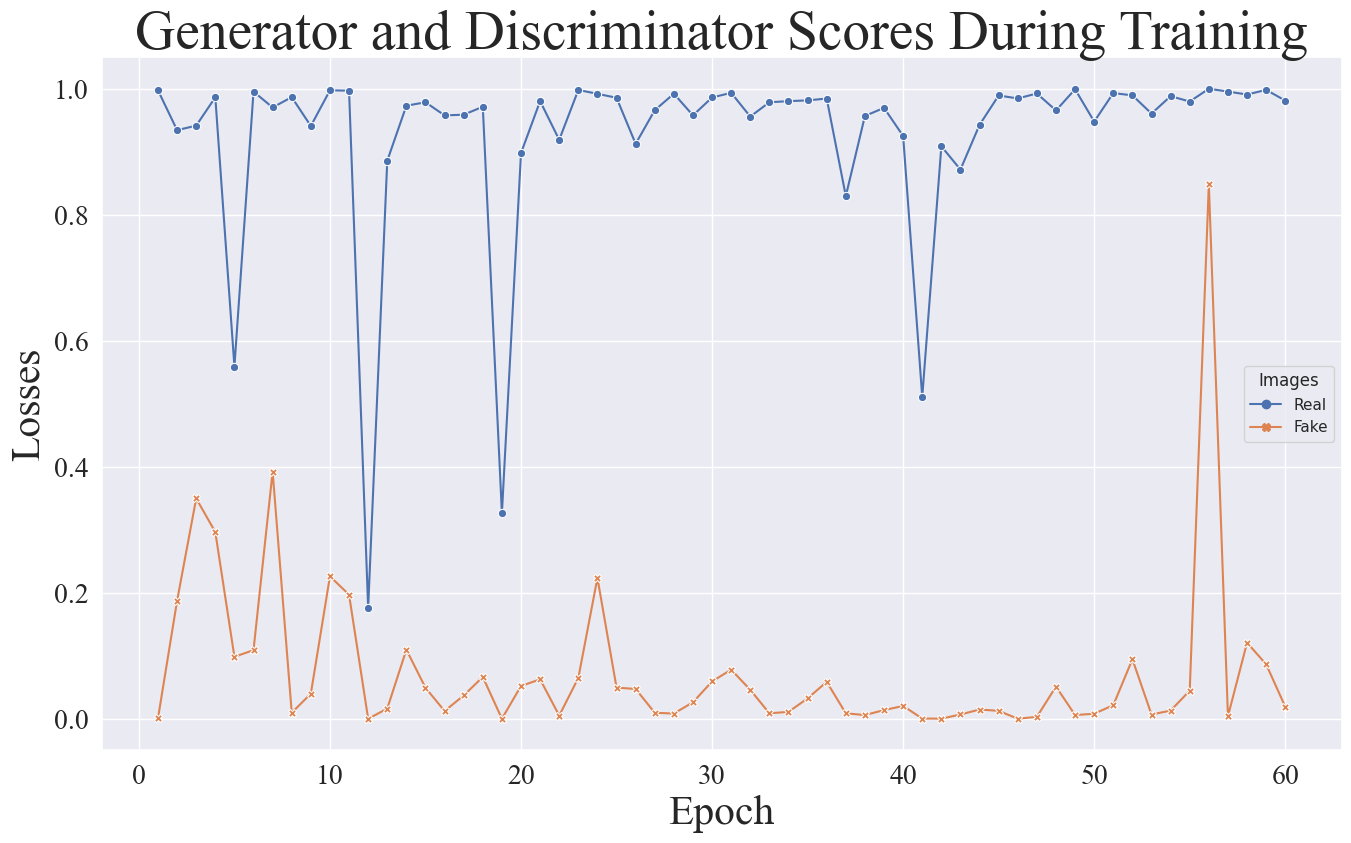

In [17]:


# Create a DF for plotting the losses.
scores_list = real_scores + fake_scores
hue_list    = ["Real"] * len(real_scores) + ["Fake"] * len(fake_scores)
epoch_list  = [i+1 for i in range(len(real_scores))] + [i+1 for i in range(len(fake_scores))] 

df_scores = pd.DataFrame({'Scores' : scores_list , 'Images' : hue_list, 'Epoch' : epoch_list})

output_file_header = "Saving_Plot_Scores_EnhancedDCGAN_"

fig= plt.figure(figsize=(16, 9))
main_color = sns.color_palette("autumn", 6)

sns.set(style = "darkgrid")

ax = sns.lineplot(data = df_scores,
                  x = "Epoch", y = "Scores", hue = "Images", style = "Images",
                  markers=True, dashes=False
                  )

#--------------------------------------------------#
font = {'family' : "Times New Roman"}
plt.rc('font', **font)
mpl.rc('font', family = 'serif', serif = "Times New Roman")
#--------------------------------------------------#
plt.rc('font', **font)
plt.rc('font', size = 20)             # controls default text sizes
plt.rc('axes', titlesize = 20)        # fontsize of the axes title
plt.rc('axes', labelsize = 20)        # fontsize of the x and y labels
#--------------------------------------------------#
plt.rc('xtick',  labelsize = 20, )    # fontsize of the tick labels
plt.rc('ytick',  labelsize = 20, )    # fontsize of the tick labels
plt.rc('legend', fontsize  = 20, )    # legend fontsize
plt.rc('figure', titlesize = 20, )    # fontsize of the figure title
#--------------------------------------------------#
plt.xticks(fontsize = 20, rotation = 0, **font)
plt.yticks(fontsize = 20, **font)
#--------------------------------------------------#
x_title = "Epoch"
y_title = "Losses"
p_title = 'Generator and Discriminator Scores During Training'
#--------------------------------------------------#
plt.xlabel(x_title, fontsize = 30, **font)
plt.ylabel(y_title, fontsize = 30, **font)
plt.title (p_title, fontsize = 40, **font)
#--------------------------------------------------#
plt.rc('font', **font)
mpl.rc('font', family = 'serif', serif = "Times New Roman")
#--------------------------------------------------#
folder = Path("./") 
fig.savefig(folder / (output_file_header + "_barplot_" + ".png") , dpi = 500 ) 
mpl.rcParams.update(mpl.rcParamsDefault)
plt.show()